In [1]:
import numpy as np
import json, os, sys, glob
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
tf.keras.backend.clear_session()

cur_path=os.getcwd()
sys.path.append(cur_path)

parent_path=os.path.abspath(os.path.join(cur_path,'..'))
sys.path.append(parent_path)

### Load Data

In [39]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Data\S9 AHI\preprocessed'

target_signal='Position'
input_signals=['Flow']#, 'mask_pressure']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor, target_tensor, subject_names = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 30,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal, levels =10,
    dataset='s9',
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import load_sig_tensor

folder_path = r'C:\Users\MichaelB9\Data\Fillius\filtered'

target_signal='Position'
input_signals=['Flow']#, 'mask_pressure']

json_files = glob.glob(os.path.join(folder_path,'*.json'))

sig_tensor1, target_tensor1, subject_names1 = load_sig_tensor(
    json_files,epoch_size = 60,epoch_step = 30,
    sample_rate = 25, input_signals=input_signals,
    target_signal=target_signal,
    dataset='fillius',
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: need at least one array to concatenate

In [23]:
sig_tensor1['Flow'].shape

(8, 39786, 1500)

In [4]:

sig_tensor['Flow']=np.concatenate([sig_tensor['Flow'], sig_tensor1['Flow']], axis = 1)
target_tensor=np.concatenate([target_tensor,target_tensor1])
subject_names=np.concatenate([subject_names,subject_names1])
sig_tensor1=[]

### Plot octave encoded signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


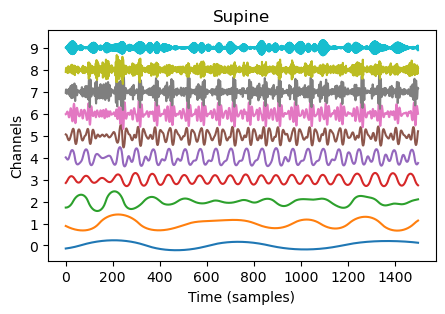

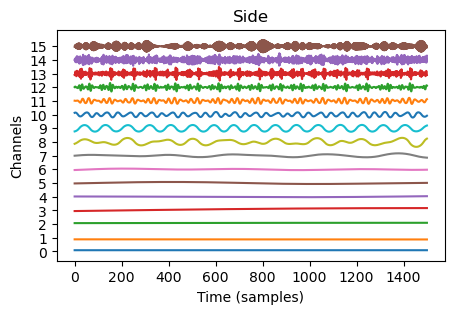

In [38]:
%load_ext autoreload
%autoreload 2
from helpers.plotting import plot_oct

plot_oct(sig_tensor['Flow'][0:10,5,:],np.where(target_tensor[3]==1,'Supine','Side'))
plot_oct(sig_tensor['Flow'][:,500,:],np.where(target_tensor[300]==1,'Supine','Side'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


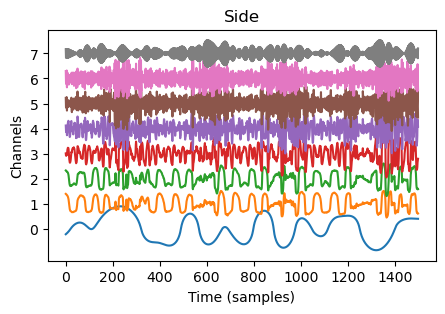

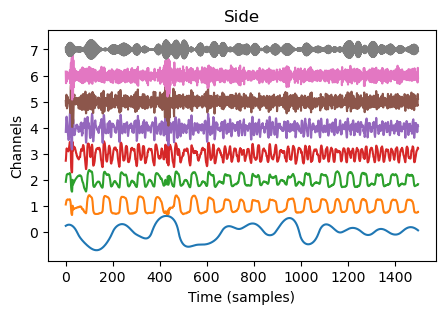

In [5]:
%load_ext autoreload
%autoreload 2
from helpers.plotting import plot_oct

plot_oct(sig_tensor['flow'][:,5,:],np.where(target_tensor[3]==1,'Supine','Side'))
plot_oct(sig_tensor['flow'][:,500,:],np.where(target_tensor[300]==1,'Supine','Side'))


## Train a standard 1d CNN

### Split the data

In [40]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

X_train, y_train, X_val, y_val, X_test, y_test, all_subs = split(sig_tensor['Flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  127  subjects
Validation Set Size =  11  subjects
Test Set Size =  12  subjects
------------------------------
train set size =  (93606, 1500, 11) 
 Target distribution 
          0
1  0.52424
0  0.47576
------------------------------
val set size =  (8026, 1500, 11) 
 Target distribution 
           0
0  0.506479
1  0.493521
------------------------------
test set size =  (8674, 1500, 11) 
 Target distribution 
          0
0  0.50807
1  0.49193
------------------------------


In [44]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()

from build_dnns import build_cnn_1D_4layer

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True,
    )

# Build model
cnn_model=build_cnn_1D_4layer(X_train.shape[1],X_train.shape[2],filters=5,kernel_size=5,n_dense=16,dropout=0.4)
# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])
# Fit model
H=cnn_model.fit(
    X_train,y_train,
    epochs=100,batch_size=64,
    shuffle=True,validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/100
1463/1463 [==============================] - 113s 71ms/step - loss: 0.6984 - accuracy: 0.5164 - val_loss: 0.6933 - val_accuracy: 0.4935
Epoch 2/100
1463/1463 [==============================] - 94s 64ms/step - loss: 0.6916 - accuracy: 0.5238 - val_loss: 0.6931 - val_accuracy: 0.4816
Epoch 3/100
1463/1463 [==============================] - 95s 65ms/step - loss: 0.6904 - accuracy: 0.5252 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 4/100
1463/1463 [==============================] - 97s 67ms/step - loss: 0.6857 - accuracy: 0.5511 - val_loss: 0.6934 - val_accuracy: 0.5097
Epoch 5/100
 277/1463 [====>.........................] - ETA: 1:30 - loss: 0.6802 - accuracy: 0.5725

In [12]:
train_val_curve(H)

<Figure size 640x480 with 0 Axes>

: 

: 

In [15]:
cnn_model.save(r'C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_01')

INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_01\assets


INFO:tensorflow:Assets written to: C:\Users\MichaelB9\Git\deepdive23\new_ml_approach\saved_models\position_model_01\assets


### Model Evaluation

272/272 [==============================] - 3s 12ms/step


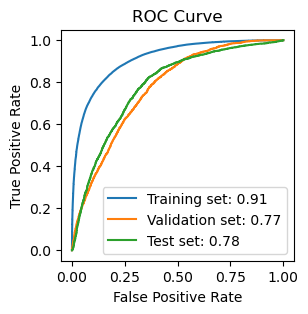

In [23]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *


y_train_pred=cnn_model.predict(X_train)
y_val_pred=cnn_model.predict(X_val)
y_test_pred=cnn_model.predict(X_test)

plt.figure(figsize=(3,3))
plot_roc(y_train,y_train_pred,0.5, label='Training set')
plot_roc(y_val,y_val_pred,0.5, label='Validation set')
plot_roc(y_test,y_test_pred,0.5, label='Test set')

In [31]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.65))

              precision    recall  f1-score   support

           0       0.76      0.64      0.69      4065
           1       0.68      0.79      0.73      3961

    accuracy                           0.72      8026
   macro avg       0.72      0.72      0.71      8026
weighted avg       0.72      0.72      0.71      8026



## Train a multiheaded model with flow and Pressure

In [41]:
%load_ext autoreload
%autoreload 2

from helpers.load_data import split

Xflow_train, y_train, Xflow_val, y_val, Xflow_test, y_test = split(sig_tensor['flow'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)
Xpres_train, _, Xpres_val, _, Xpres_test, _ = split(sig_tensor['mask_pressure'],target_tensor,subject_names,train_size=0.85,val_size=0.075,test_size=0.075)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  39  subjects
Validation Set Size =  3  subjects
Test Set Size =  5  subjects
------------------------------
train set size =  (16627, 1500, 8) 
 Target distribution 
           0
1  0.516088
0  0.483912
------------------------------
val set size =  (1119, 1500, 8) 
 Target distribution 
           0
1  0.589812
0  0.410188
------------------------------
test set size =  (2147, 1500, 8) 
 Target distribution 
           0
1  0.570098
0  0.429902
------------------------------
------------------------------
Train-test-validation split
------------------------------
Training Set Size =  39  subjects
Validation Set Size =  3  subjects
Test Set Size =  5  subjects
------------------------------
train set size =  (16627, 1500, 8) 
 Target distribution 
           0
1  0.516088
0  0.483912
------

In [42]:
%load_ext autoreload
%autoreload 2
tf.keras.backend.clear_session()
from build_dnns import build_2head_cnn

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

cnn_model2head=build_2head_cnn(Xflow_train.shape[1],Xflow_train.shape[2],filters=16,kernel_size=16,n_dense=16,dropout=0.3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)    
cnn_model2head.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy'])

H=cnn_model2head.fit(
    [Xflow_train,Xpres_train],y_train, 
    epochs=15,batch_size=64,
    shuffle=True,validation_data=([Xflow_val,Xpres_val],y_val), 
    callbacks=[early_stopping],
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/15
260/260 [==============================] - 14s 51ms/step - loss: 0.6995 - accuracy: 0.5146 - val_loss: 0.6852 - val_accuracy: 0.5898
Epoch 2/15
260/260 [==============================] - 14s 54ms/step - loss: 0.6847 - accuracy: 0.5465 - val_loss: 0.6866 - val_accuracy: 0.5648
Epoch 3/15
260/260 [==============================] - 16s 60ms/step - loss: 0.6652 - accuracy: 0.5952 - val_loss: 0.7142 - val_accuracy: 0.5907
Epoch 4/15
260/260 [==============================] - 15s 58ms/step - loss: 0.6303 - accuracy: 0.6520 - val_loss: 0.7457 - val_accuracy: 0.5550
Epoch 5/15
260/260 [==============================] - 17s 64ms/step - loss: 0.5767 - accuracy: 0.7119 - val_loss: 0.9964 - val_accuracy: 0.5657
Epoch 6/15
260/260 [==============================] - 15s 58ms/step - loss: 0.5480 - accuracy: 0.7309 - val_loss: 0.8721 - val_accuracy: 0.5648
Epoch 6: early stopping


### Model Evaluation

68/68 [==============================] - 0s 4ms/step


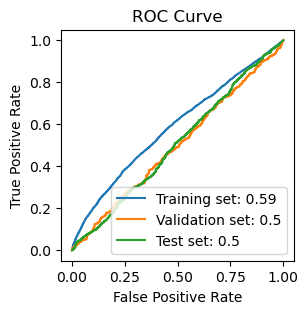

In [43]:
from helpers.plotting import train_val_curve, plot_roc
from sklearn.metrics import *

# train_val_curve(H)

y_train_pred=cnn_model2head.predict([Xflow_train,Xpres_train])
y_val_pred=cnn_model2head.predict([Xflow_val, Xpres_val])
y_test_pred=cnn_model2head.predict([Xflow_test, Xpres_test])

plt.figure(figsize=(3,3))
plot_roc(y_train,y_train_pred,0.5, label='Training set')
plot_roc(y_val,y_val_pred,0.5, label='Validation set')
plot_roc(y_test,y_test_pred,0.5, label='Test set')

In [44]:
print(classification_report(y_val,sp.ndimage.median_filter(y_val_pred,15)>0.5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.59      1.00      0.74       660

    accuracy                           0.59      1119
   macro avg       0.29      0.50      0.37      1119
weighted avg       0.35      0.59      0.44      1119



c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MichaelB9\Anaconda3\envs\deepdive\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
